
使用pytorch達成風格轉換
=============================
主要參考 : https://pytorch.org/tutorials/advanced/neural_style_tutorial.html<br>
作者 : 湯沂達 https://github.com/mistake0316

-------------
![](https://i.imgur.com/kvKNdPl.png)
## 簡介
Pytorch官方文件旨在復現論文 `A Neural Algorithm of Artistic Style
 <https://arxiv.org/abs/1508.06576>`的方法，該方法由Leon A. Gatys, Alexander S. Ecker and Matthias Bethge 在2015年八月所提出。


類神經風格轉換允許我們創造一張富有風格感的新影像。如上圖所示，演算法將左方影像增添中間風格得到右方結果。

其中三張影像由左至右的名詞為
* 內容影像 (contentimage : $I_c$)
* 風格影像 (style image : $I_s$)
* 風格化結果 (stylized result : $I$)


## 演算法概念
想法的核心概念其實非常的簡單
1. 目標是找到一張影像
2. 該影像有內容影像的內容
3. 該影像有風格影像的風格

將其變換為演算法
1. 可變動參數為一張影像$I$，要找到對應總損失函數中最小的那張，(總損失函數：$\alpha L_{content}(I, I_c) + \beta L_{style}(I, I_s)$
2. (content loss : $L_{content}$) 內容損失函數是量測找到的影像 $I$ 以及原始影像 $I_c$ 在某個特徵表達底下的距離
$$
L_{content}(I_1, I_2) = \sum\left(F(I_1)-F(I_2)\right)^2
$$
> 其中上方$F$為$VGG_{\text{conv4_2}}$，以原始影像為$(512, 512, 3)$為例，輸出後的維度為$(64,64,512)$，計算損失函數時要將所有值相減，平方後再加起，得到內容損失函數<br>
> 註：原文採用VGG的`conv4_2`的輸出結果 
3. (style loss : $L_{style}$) 風格損失函數不像內容損失函數一樣，是直接量測兩張影像特徵的距離。取而代之的，這損失函數量測的是特徵的<font color="#FF9999" size="4.5em">統計量</font>的距離
$$
L_{style}(I_1, I_2) = \sum\left(G(I_1)-G(I_2)\right)^2
$$
其中$G$是Gram Matrix，對維度為(H,W,C)的張量計算後是一個維度為(C,C)的矩陣，其計算方法是
$$
G(I)_{i,j} = mean_{x,y}(F(I)_{x,y,i} \cdot F(I)_{x,y,j})
$$
> 值得注意的點是，不管輸入影像大小多大，其Gram-Matrix的維度皆一致<br>
> 原文採用VGG五層：`conv1_1`, `conv2_1`, `conv3_1`, `conv4_1`, `conv5_1`的Gram-matrix來計算風格損失

<img src="https://imgur.com/L119232.jpg"/>

In [ ]:
#@title 導入函式庫
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import plotly.express as px

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title 下載影像
!rm -rf Neural-Style-Transfer
!git clone https://github.com/titu1994/Neural-Style-Transfer
!mv ./Neural-Style-Transfer/images/inputs ./images
!rm -rf Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1421 (delta 8), reused 12 (delta 4), pack-reused 1393
Receiving objects: 100% (1421/1421), 68.19 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [ ]:
content_paths = os.listdir("images/content")
content_paths

['ancient_city.jpg',
 'golden_gate.jpg',
 'Dipping-Sun.jpg',
 'Sunlit Mountains.jpg',
 'Japanese-cherry-widescreen-wallpaper-Picture-1366x768.jpg',
 'winter-wolf.jpg',
 'blue-moon-lake.jpg',
 'Kinkaku-ji.jpg',
 'sagano_bamboo_forest.jpg',
 'Dawn Sky.jpg',
 'Aurea-Luna.jpg',
 'tubingen.jpg']

In [ ]:
style_paths = os.listdir("images/style")
style_paths

['japanese_flower_sakai_hoitsu.jpg',
 'metals',
 'blue_swirls.jpg',
 'bamboo_forest.jpg',
 'picasso_selfport1907.jpg',
 'escher_sphere.jpg',
 'starry_night.jpg',
 'japanese_painting.jpg',
 'shipwreck.jpg',
 'Blue Strokes.jpg',
 'woman-with-hat-matisse.jpg',
 'red-canna.jpg',
 'misty-mood-leonid-afremov.jpg',
 'frida_kahlo.jpg',
 'seated-nude.jpg',
 'starry_night_crop.png',
 'patterned_leaves.jpg',
 'candy-style.jpg',
 'water-lilies-1919-2.jpg',
 'wave_kanagawa.jpg',
 'the_scream.jpg']

In [ ]:
# desired size of the output image
imsize = 512 #@param {type:"number"}

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_path = "./images/content/Kinkaku-ji.jpg" #@param {type:"string"}
style_path = "./images/style/starry_night.jpg" #@param {type:"string"}

content_img = image_loader(content_path)
style_img = image_loader(style_path)

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    px.imshow(image, title=title).show()
    
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')

## 損失函數


### 內容損失函數
深層均方差

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.clone().detach()

    def forward(self, input):
        loss = F.mse_loss(input, self.target)
        return loss

### 風格損失函數
Gram Matrix的均方差
```python
# 原版程式碼，不過我比較喜歡用einsum
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
```

In [ ]:
def gram_matrix(input):
  G = torch.einsum(
      "bixy,bjxy->bij",
      input,
      input
  )
  return G/input.numel()

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).clone().detach()

    def forward(self, input):
        G = gram_matrix(input)
        loss = F.mse_loss(G, self.target)
        return loss

## 特徵模型 VGG 19



In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG的前處理要將輸入經過平移、縮放<br>
平均值 : [0.485, 0.456, 0.406]<br>
標準差 : [0.229, 0.224, 0.225]




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1).clone().detach()
        self.std = std.view(-1, 1, 1).clone().detach()

    def forward(self, img):
        return (img - self.mean) / self.std

### 對應層名稱輸出


In [ ]:
set(list(map(type, cnn)))

{torch.nn.modules.activation.ReLU,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.pooling.MaxPool2d}

In [ ]:
def get_feature(
    input,
    content_layers_name:list,
    style_layers_name:list,
  ):
  name_pool = set(style_layers_name) | set(content_layers_name)
  out_pool = dict()

  x = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)(input)
  block = 1
  layer = 0
  for l in cnn:
    if isinstance(l, nn.MaxPool2d):
      block += 1
      layer = 0
      name = f"pool_{block}"
    elif isinstance(l, nn.Conv2d):
      layer += 1
      name = f"conv{block}_{layer}"
    elif isinstance(l, nn.ReLU):
      name = f"relu{block}_{layer}"
    else:
      raise ValueError(f"{type(l)} should in MaxPool2d, Conv2d, ReLU")

    x = l(x)
    if name in name_pool:
      out_pool[name] = x
      name_pool.remove(name)
    
    if len(name_pool) == 0:
      break
  
  return {
      "content" : {name:out_pool[name] for name in content_layers_name},
      "style" : {name:out_pool[name] for name in style_layers_name},
  }

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv4_2']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_losses(content_img,style_img,
              content_layers=content_layers_default,
              style_layers=style_layers_default):
    
    # just in order to have an iterable access to or list of content/syle
    # losses

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    content_losses = {
      key:ContentLoss(value) for key, value in get_feature(content_img, content_layers,[])["content"].items()
    }
    
    style_losses = {
      key:StyleLoss(value) for key, value in get_feature(style_img, [],style_layers)["style"].items()
    }

    # now we trim off the layers after the last content and style losses
    return style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




## 梯度下降


作者的建議是使用LBFGS 
> 原文網址：`https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq`

不過其實想要用什麼樣的優化器都可以。




In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

最後把所有東西打包成一個函式，其中我們除了內容、風格損失函數之外，額外新增了一個Total Variation Loss，其損失函數是相鄰像素的均方差。新增此損失函數可以避免相鄰像素變化太劇烈

In [ ]:
def run_style_transfer(content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000,
                       content_weight=1,
                       total_variation_weight=1000,
                       content_layers=content_layers_default,
                       style_layers=style_layers_default,
                       ):
    """Run the style transfer."""
    print('Building the style transfer model..')
    style_losses, content_losses = get_losses(
      content_img,
      style_img,
      content_layers=content_layers,
      style_layers=style_layers
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    cnn.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            features = get_feature(input_img, content_layers, style_layers)
            style_score = 0
            content_score = 0
            total_variation_score = 0.5*(
                ((input_img[:,:,:,:-1]-input_img[:,:,:,1:])**2).mean()
               +((input_img[:,:,:-1,:]-input_img[:,:,1:,:])**2).mean()
            )

            for name, feature in features["style"].items():
              style_score += style_losses[name](feature)
            
            for name, feature in features["content"].items():
              content_score += content_losses[name](feature)
            
            style_score *= style_weight
            content_score *= content_weight
            total_variation_score *= total_variation_weight

            loss = style_score + content_score + total_variation_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Total Variation: {:4f}'.format(
                    style_score.item(), content_score.item(), total_variation_score.item()))
                imshow(input_img, title=f"step:{run[0]}")
                print()

            return style_score + content_score + total_variation_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


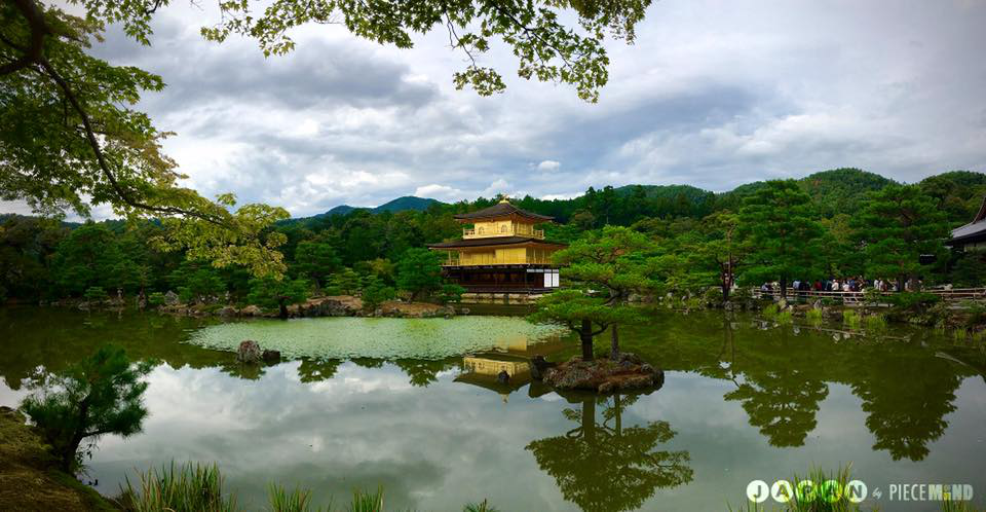

In [ ]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')

Finally, we can run the algorithm.




In [ ]:
output = run_style_transfer(
    content_img, style_img, input_img,
    content_weight=1,
    style_weight=1000000,
    total_variation_weight=1000
)

imshow(output, title='Output Image')

# 練習：
1. 試著把輸入從content image替換成隨機雜訊，並比較差異
2. 試著讓content loss weight為0（只使用style weight）
3. 試著讓content layer靠近或遠離輸出層
4. 嘗試縮小或放大style image, 觀察輸出影像的筆觸變化